## Preprocessing

In [7]:
import os
!pip install opencv-python-headless
import cv2
import numpy as np
import pandas as pd
!pip install tensorflow-macos
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import zipfile

### Extracting Videos (MP4 Format)

In [12]:
data_dir = "Data/"
extract_to = "Data/extracted_videos/"

os.makedirs(extract_to, exist_ok=True)

for file in ["dfdc_train_part_00.zip", "dfdc_train_part_01.zip", "dfdc_train_part_02.zip"]:
    with zipfile.ZipFile(os.path.join(data_dir, file), 'r') as zip_ref:
        zip_ref.extractall(extract_to)

print("Extraction complete")


Extraction complete


### Counting Frames from MP4 Data (See frame_extraction.py and Data/frames for more)

In [20]:
import os

frame_dir = "Data/frames/"
total_frames = sum(len(files) for _, _, files in os.walk(frame_dir))

print(f"Total frames extracted: {total_frames}")


Total frames extracted: 52591


### Merge Metadata.json files (Labeled Data for Reference)

In [43]:
import os
import pandas as pd
import json

frame_dir = "Data/frames/"
video_dir = "Data/extracted_videos/"
metadata_files = []  

for folder in os.listdir(video_dir):
    folder_path = os.path.join(video_dir, folder)
    metadata_path = os.path.join(folder_path, "metadata.json")
    if os.path.exists(metadata_path):
        metadata_files.append(metadata_path)

print(f"Found {len(metadata_files)} metadata files.")

metadata = {}
for meta_file in metadata_files:
    with open(meta_file, "r") as f:
        meta_data_part = json.load(f)
        metadata.update(meta_data_part)  # Merge into one dictionary

print(f"Merged metadata contains {len(metadata)} videos.")

data = []
missing_videos = 0

for video_name in os.listdir(frame_dir):
    video_path = os.path.join(frame_dir, video_name)

    video_file_name = video_name + ".mp4"  

    if os.path.isdir(video_path) and video_file_name in metadata:
        label = metadata[video_file_name]["label"]  
        
        for frame in os.listdir(video_path):
            frame_path = os.path.join(video_path, frame)
            data.append([frame_path, label])
    else:
        missing_videos += 1

print(f"⚠️ {missing_videos} frame folders do not have matching metadata entries.")

df = pd.DataFrame(data, columns=["frame_path", "label"])
df.to_csv("Data/frames_metadata.csv", index=False)

print(f"Metadata CSV saved with {len(df)} labeled frame samples.")


✅ Found 3 metadata files.
✅ Merged metadata contains 4781 videos.
⚠️ 0 frame folders do not have matching metadata entries.
✅ Metadata CSV saved with 52591 labeled frame samples.


In [81]:
import pandas as pd
# data examples
df = pd.read_csv("Data/frames_metadata.csv")
print(df.head())
print(df["label"].value_counts())


                             frame_path label
0   Data/frames/gwxegwtsaj/frame_58.jpg  FAKE
1  Data/frames/gwxegwtsaj/frame_174.jpg  FAKE
2  Data/frames/gwxegwtsaj/frame_203.jpg  FAKE
3  Data/frames/gwxegwtsaj/frame_261.jpg  FAKE
4  Data/frames/gwxegwtsaj/frame_116.jpg  FAKE
label
FAKE    47927
REAL     4664
Name: count, dtype: int64


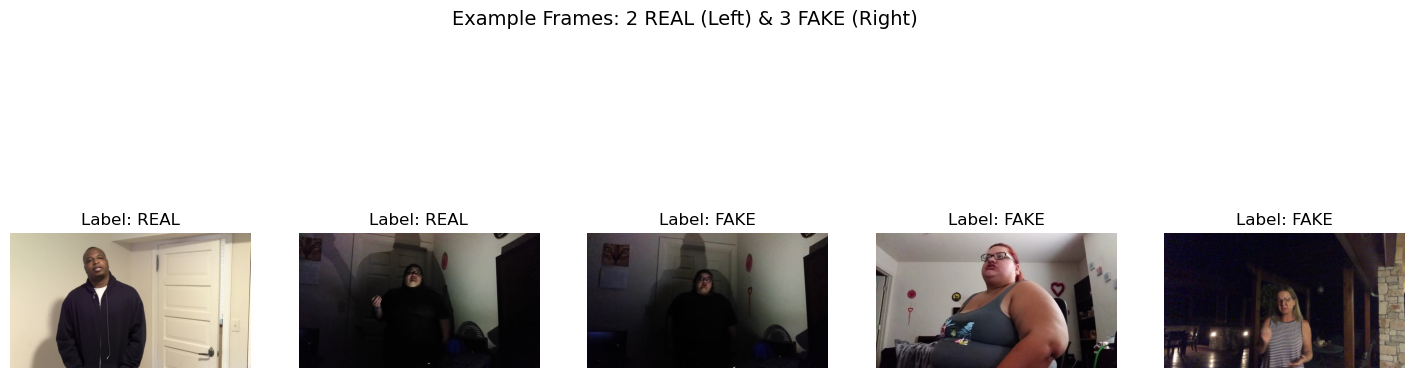

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Load dataset
df = pd.read_csv("Data/frames_metadata.csv")

# Select 2 REAL and 3 FAKE samples
real_samples = df[df['label'] == "REAL"].sample(2, random_state=42)  # Ensure reproducibility
fake_samples = df[df['label'] == "FAKE"].sample(3, random_state=42)

# Combine into one dataframe for visualization
selected_samples = pd.concat([real_samples, fake_samples])

# Plot the selected frames
fig, axes = plt.subplots(1, 5, figsize=(18, 6))
fig.suptitle("Example Frames: 2 REAL (Left) & 3 FAKE (Right)", fontsize=14)

for i, row in enumerate(selected_samples.iterrows()):
    img_path = row[1]['frame_path']
    img = Image.open(img_path)
    
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {row[1]['label']}", fontsize=12)

plt.show()


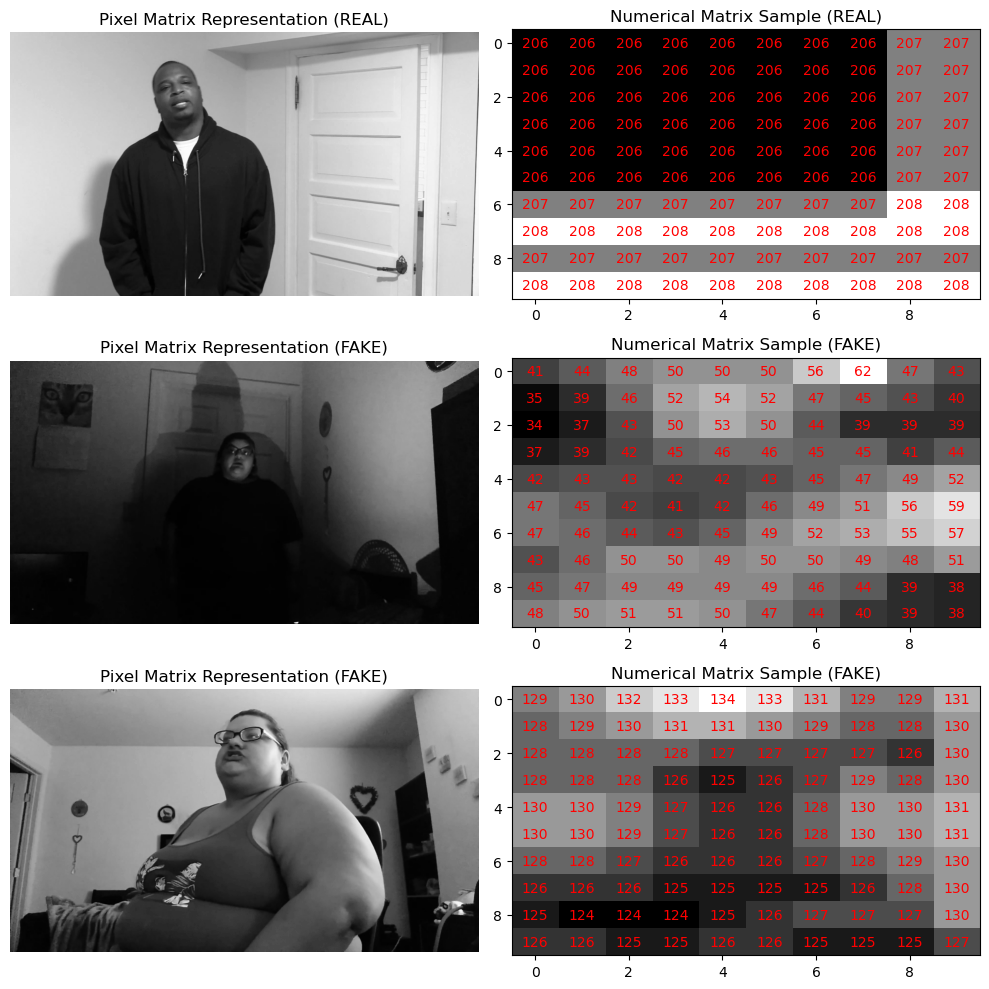

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# This is an example of the matrix representation of both fake and real frames, essentially what the model is being trained on.
real_samples = df[df['label'] == "REAL"].sample(1, random_state=42)
fake_samples = df[df['label'] == "FAKE"].sample(2, random_state=42)

selected_samples = pd.concat([real_samples, fake_samples])

fig, axes = plt.subplots(len(selected_samples), 2, figsize=(10, 10))

for i, row in enumerate(selected_samples.iterrows()):
    img_path = row[1]['frame_path']
    img = Image.open(img_path).convert("L")
    img_matrix = np.array(img)

    matrix_crop = img_matrix[:10, :10]

    axes[i, 0].imshow(img_matrix, cmap="gray")
    axes[i, 0].set_title(f"Pixel Matrix Representation ({row[1]['label']})")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(matrix_crop, cmap="gray", aspect="auto")
    axes[i, 1].set_title(f"Numerical Matrix Sample ({row[1]['label']})")

    for x in range(matrix_crop.shape[0]):
        for y in range(matrix_crop.shape[1]):
            axes[i, 1].text(y, x, str(matrix_crop[x, y]), ha='center', va='center', color='red')

plt.tight_layout()
plt.show()


### Convert Data Structure to Tensor (Check dataset.py)

In [55]:
import sys
sys.path.append("Scripts")

import importlib
import dataset
importlib.reload(dataset)

from dataset import DeepfakeDataset, transform


In [56]:
import pandas as pd

metadata_path = "Data/frames_metadata.csv"
df = pd.read_csv(metadata_path)
dataset_instance = DeepfakeDataset(df, transform=transform)


In [57]:
import importlib
import dataset
importlib.reload(dataset)
from dataset import DeepfakeDataset, transform

import pandas as pd

metadata_path = "Data/frames_metadata.csv"
df = pd.read_csv(metadata_path)
dataset_instance = DeepfakeDataset(df, transform=transform)

sample_image, sample_label = dataset_instance[0]
print(type(sample_image))
print(sample_image.size())
print(sample_label) 


<class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor(1)


## DL Model

### DL Training

Model selection description: 

I use EfficientNetB0 as the feature extractor for the deep learning model. EfficientNet is a convolutional neural network (CNN) architecture that balances model depth, width, and resolution to optimize performance.

This CNN is particularly useful for image-based tasks like deepfake detection because it:

Preserves fine-grained image features, which are necessary for identifying manipulated material.
Performs well with fewer parameters, making it efficient compared to deeper models like ResNet or Xception.
Has been successfully used in prior deepfake detection research (Heidari et al., 2024).

In this project, I train EfficientNetB0 on deepfake frame data, aiming to evaluate how well it distinguishes deepfake frames from real ones.



In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import torch.optim as optim

# -------------------------------
# 1.I load metadata and encode labels
# -------------------------------
metadata_path = "Data/frames_metadata.csv"
df = pd.read_csv(metadata_path)

label_map = {"REAL": 0, "FAKE": 1}
df["label"] = df["label"].map(label_map)

# -------------------------------
# 2. I define the data transformations
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),        
    transforms.RandomHorizontalFlip(),     
    transforms.ToTensor(),                 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

# -------------------------------
# 3. I define the custom dataset
# -------------------------------
class DeepfakeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]["frame_path"]
        label = self.dataframe.iloc[idx]["label"]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

dataset = DeepfakeDataset(df, transform=transform)

# -------------------------------
# 4. I split the dataset and create dataLoaders
# -------------------------------
# Split into train (70%), val (15%), test (15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
}

# -------------------------------
# 5. I use the EfficientNet model (image feature extractor) to train deepfake images
# -------------------------------
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# -------------------------------
# 6. I define the loss function and optimizer
# -------------------------------
class_weights = torch.tensor([
    len(df[df['label'] == 1]) / len(df), 
    len(df[df['label'] == 0]) / len(df)   
]).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# -------------------------------
# 7. Training loop
# -------------------------------
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloaders['train']:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(dataloaders['train'].dataset)
    train_acc = correct / total

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloaders['val']:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved")

# -------------------------------
# 8. Final testing phase
# -------------------------------
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in dataloaders['test']:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
test_acc = correct / total

print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Dataset loaded: {len(train_set)} train, {len(val_set)} val, {len(test_set)} test")

The training took a  long time (about 33 hours) so I will paste the results from the training cell below as I unintentionally executed the cell again and do not 33 hours to spare:

Epoch 1/10 | Train Loss: 0.5581 | Train Acc: 0.8121 | Val Acc: 0.8296 Best model saved 

Epoch 2/10 | Train Loss: 0.4403 | Train Acc: 0.8406 | Val Acc: 0.8955 Best model saved 

Epoch 3/10 | Train Loss: 0.3638 | Train Acc: 0.8727 | Val Acc: 0.9017 Best model saved 

Epoch 4/10 | Train Loss: 0.3168 | Train Acc: 0.8891 | Val Acc: 0.9104 Best model saved 

Epoch 5/10 | Train Loss: 0.2946 | Train Acc: 0.9032 | Val Acc: 0.9340 Best model saved 

Epoch 6/10 | Train Loss: 0.2678 | Train Acc: 0.9125 | Val Acc: 0.9267 

Epoch 7/10 | Train Loss: 0.2561 | Train Acc: 0.9152 | Val Acc: 0.9244 

Epoch 8/10 | Train Loss: 0.2385 | Train Acc: 0.9230 | Val Acc: 0.9172 

Epoch 9/10 | Train Loss: 0.2214 | Train Acc: 0.9261 | Val Acc: 0.9414 Best model saved 

Epoch 10/10 | Train Loss: 0.2128 | Train Acc: 0.9276 | Val Acc: 0.9375 

Final Test Accuracy: 0.9368 Dataset loaded: 36813 train, 7888 val, 7890 test


In [121]:
#This part is necessary so that I can load the data without needing to retrain
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import pandas as pd

metadata_path = "Data/frames_metadata.csv"
df = pd.read_csv(metadata_path)

label_map = {"REAL": 0, "FAKE": 1}
df["label"] = df["label"].map(label_map)

# Define the same transforms as before
transform = transforms.Compose([
    transforms.Resize((224, 224)),         
    transforms.ToTensor(),                   
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class DeepfakeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]["frame_path"]
        label = self.dataframe.iloc[idx]["label"]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

dataset = DeepfakeDataset(df, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_set, batch_size=batch_size, shuffle=False)
}

print("Data reloaded, dataloaders recreated")


Data reloaded, dataloaders recreated


In [124]:
from torchvision import models
import torch.nn as nn

# I need this block to recreate the DL model architecture
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.load_state_dict(torch.load("Models/best_model.pth"))
model.eval()

print("Deep Learning Model Reloaded Successfully")

import torch
torch.save(model.state_dict(), "deepfake_deep_learning_model.pth")

Deep Learning Model Reloaded Successfully


### DL Model Results

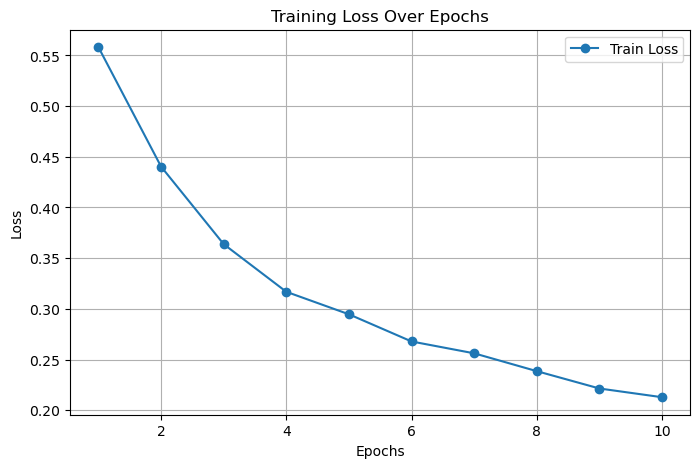

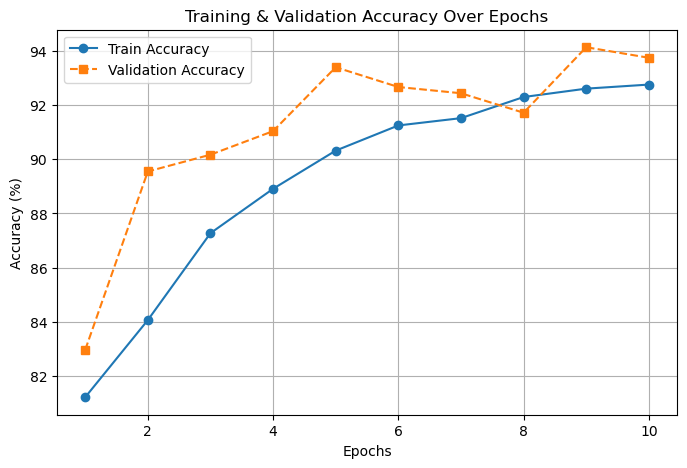

In [59]:
import matplotlib.pyplot as plt

#I Manually input logs from console output
epochs = list(range(1, 11))
train_losses = [0.5581, 0.4403, 0.3638, 0.3168, 0.2946, 0.2678, 0.2561, 0.2385, 0.2214, 0.2128]
train_accuracies = [81.21, 84.06, 87.27, 88.91, 90.32, 91.25, 91.52, 92.30, 92.61, 92.76]
val_accuracies = [82.96, 89.55, 90.17, 91.04, 93.40, 92.67, 92.44, 91.72, 94.14, 93.75]

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label="Train Loss", marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o', linestyle='-')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='s', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()


Epoch results explanation:

The first plot (training over epochs) shows a consistent decrease in training loss over 10 epochs—indicating that the model is learning effectively—as the model is minimizing the error between predictions and ground truth.

The second plot (training and validation accuracy over epochs) compares training accuracy and validation accuracy. The validation accuracy improves alongside the training accuracy, reaching a height of about 94% at epoch 10. There are fluctuations in validation accuracy, which is expected due to the variance in model generalization.

In [125]:
import torch
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

#I am extracting the precision, recall, and F1 scores for both the FAKE and REAL classes.
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in dataloaders['test']:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print("\nPrecision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1-score:", round(f1, 4))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['REAL', 'FAKE']))



Precision: 0.9826
Recall: 0.9594
F1-score: 0.9708

Classification Report:
               precision    recall  f1-score   support

        REAL       0.67      0.83      0.74       706
        FAKE       0.98      0.96      0.97      7184

    accuracy                           0.95      7890
   macro avg       0.82      0.89      0.85      7890
weighted avg       0.95      0.95      0.95      7890



DL Model Classification report explanation:

There is a higher overall accuracy (95%) suggesting that the model is performing well in general for both real and fake frames. The precision for real (0.67) is relatively low when compared to fake (0.98) suggesting that many real frames were misclassified as fake. The recall also follows a similar pattern. The F1 score for real (0.74) indicates that the model is only somewhat confident in real frame detection while being very confident in fake frame detection (0.97), as this is a measurement of the balance between precision and recall. 

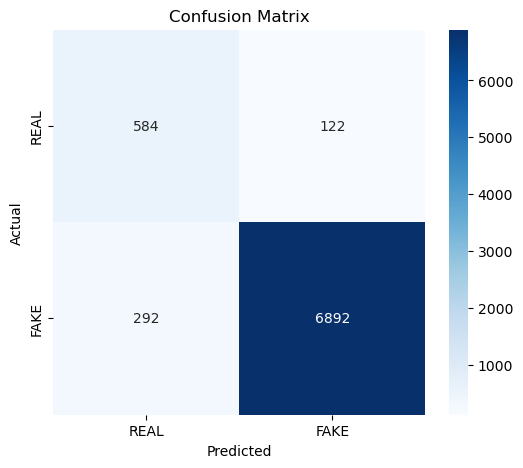

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# I compute a confusion matrix here
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Confusion matrix explanation:

The matrix deomonstrates that the model performed exceptionally well in detecting fake images, with few false negatives. However, the model clearly struggled with correctly identifying real images, as suggested by the higher number of misclassified frames as fake (when they were real)—suggesting that real samples are underrepresented (or have less distinguishable features in the dataset)—leading to a classification imbalance

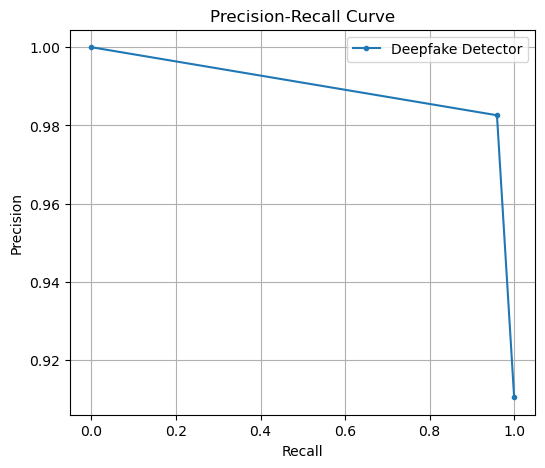

In [132]:
from sklearn.metrics import precision_recall_curve

# I get precision and recall values here and plot them
precision, recall, _ = precision_recall_curve(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, marker='.', label='Deepfake Detector')
plt.xlabel('Recall') 
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


Precision-Recall Curve Description:

The model maintains high precision (around 98-100%) which indicates relatively few false positives. The recall is also high (around 99%), suggesting that the model is detecting almost all fake frames properly. The sharp drop indicates that, at the highest recall, precision significantly decrease, likely due to some real frames being misclassified as fake.

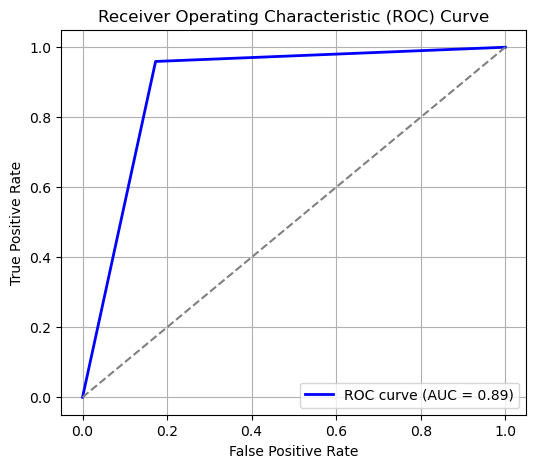

In [133]:
from sklearn.metrics import roc_curve, auc

# I compute ROC curve here
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()


ROC AUC Curve Explanation:

This visualization helps evaluate the model's ability to distinguish between real and fake frames. The AUC curve (around .90 suggests that the odel performs well, but is not perfect). The sharp rise in TP rates at low FP rates indicates that model was initially making many correct predictions with few mistakes. However, the flattening near the top indicates that, at high sensitivities, the FP rate increases.

### Machine Learning Model

Why conduct hyperparameter tuning:

HPT optimizes the Random Forest Model by searching for the best combination of parameters that lead to higher accuracy, lower error rates, and overall improved generalization. I used RandomizedSearchCV over GridSearchCV for time efficiency. I also limited the number of trees in the forest (n_estimators), max depth, and leaf samples to control complexity, overfitting, and generalization, as this model can easily become extremely complex with the given data. These limitations also reduce computational and time costs of hyperparameter optimization, which would be significantly higher from GridSearchCV (GridSearchCV exhaustively searches all parameter combinations while RandomizedSearchCV samples from a defined distribution of parameters while maintaining strong model performance).

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
from joblib import dump

# I am hyperparameter tuning here (made feasible for the timeframe)
param_dist = {
    'n_estimators': [100, 200],  
    'max_depth': [10, 20, None],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],  
    'max_features': ['sqrt'] 
}

rf_model = RandomForestClassifier(random_state=42, warm_start=True)

random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_dist, 
    n_iter=10,  
    scoring='f1', 
    cv=2,  
    n_jobs=-1, 
    verbose=2, 
    random_state=42,
    return_train_score=True,  
    pre_dispatch="2*n_jobs"  
)

print("Starting Randomized Search...")
random_search.fit(X_train, y_train)
print("Hyperparameter tuning completed!")

best_rf_model = random_search.best_estimator_
print("Best Parameters Found:", random_search.best_params_)

dump(best_rf_model, "deepfake_ml_model_optimized.joblib")
print("Optimized ML Model Saved.")

results_df = pd.DataFrame(random_search.cv_results_)
results_df.to_csv("random_search_results.csv", index=False)
print("Partial training results saved to 'random_search_results.csv'.")


Starting Randomized Search...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.3min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.3min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.6min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.7min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 5.8min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min

In [82]:
import pandas as pd

results_df = pd.read_csv("random_search_results.csv")

# Find the best performing parameters
best_index = results_df["mean_test_score"].idxmax()
best_params = results_df.iloc[best_index]["params"]

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}


### ML RandomForest Training

Why I chose this model as the ML model for the project:

Random Forest was the best choice for the ML component of this project due to the high-dimensional nature of frame data. RF models are inherently robust because they aggregate multiple decision trees—improving generalization and reducing overfitting. RF efficiently handles high-dimensional data by randomly selecting a subset of features at each split, making it effective even when dealing with thousands of extracted image features.

In [95]:
import pandas as pd
import numpy as np
import torch
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_ml = pd.read_csv("Data/frames_metadata.csv")

label_map = {"REAL": 0, "FAKE": 1}
df_ml["label"] = df_ml["label"].map(label_map)

def extract_image_features(image_path):
    from PIL import Image
    from torchvision import transforms

    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])
    image = transform(image)
    return image.numpy().flatten()

df_ml["features"] = df_ml["frame_path"].apply(extract_image_features)
X = np.stack(df_ml["features"].values)
y = df_ml["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

best_rf_model = RandomForestClassifier(
    n_estimators=200, 
    min_samples_split=2, 
    min_samples_leaf=2,
    max_features='sqrt', 
    max_depth=10, 
    random_state=42
)

print("Training the final optimized model...")
best_rf_model.fit(X_train, y_train)

dump(best_rf_model, "Models/deepfake_ml_model_final.joblib")
print("Final Optimized Model Saved as 'Models/deepfake_ml_model_final.joblib'.")


Training the final optimized model...
Final Optimized Model Saved as 'Models/deepfake_ml_model_final.joblib'.


### Validation Set

I still want to see how other parameters effect my model even though I leveraged hyperparameter tuning to extract strong parameters. Therefore, the following code is testing a few iterations of other parameters.

In [135]:
import pandas as pd
import numpy as np
import torch
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

df_ml = pd.read_csv("Data/frames_metadata.csv")
label_map = {"REAL": 0, "FAKE": 1}
df_ml["label"] = df_ml["label"].map(label_map)

def extract_image_features(image_path):
    from PIL import Image
    from torchvision import transforms
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
    image = transform(image)
    return image.numpy().flatten()

df_ml["features"] = df_ml["frame_path"].apply(extract_image_features)
X = np.stack(df_ml["features"].values)
y = df_ml["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

param_configs = [
    {"n_estimators": 50, "max_depth": 5, "min_samples_split": 2, "min_samples_leaf": 1, "max_features": "sqrt"},
    {"n_estimators": 100, "max_depth": 10, "min_samples_split": 5, "min_samples_leaf": 2, "max_features": "sqrt"},
    {"n_estimators": 200, "max_depth": None, "min_samples_split": 2, "min_samples_leaf": 2, "max_features": "sqrt"}
]

results = []
for i, params in enumerate(param_configs):
    print(f"\nTraining Model {i+1} with Params: {params}")
    rf_model = RandomForestClassifier(**params, random_state=42)
    rf_model.fit(X_train, y_train)

    y_val_pred = rf_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    report = classification_report(y_val, y_val_pred, target_names=["REAL", "FAKE"], output_dict=True)

    results.append({
        "Model": f"Config {i+1}",
        "Accuracy": accuracy,
        "Precision_Real": report["REAL"]["precision"],
        "Recall_Real": report["REAL"]["recall"],
        "F1_Real": report["REAL"]["f1-score"],
        "Precision_Fake": report["FAKE"]["precision"],
        "Recall_Fake": report["FAKE"]["recall"],
        "F1_Fake": report["FAKE"]["f1-score"],
    })

results_df = pd.DataFrame(results)
display(results_df)



Training Model 1 with Params: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Training Model 2 with Params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}

Training Model 3 with Params: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


,Model,Accuracy,Precision_Real,Recall_Real,F1_Real,Precision_Fake,Recall_Fake,F1_Fake
0,Config 1,0.917089,1.000000,0.070234,0.131250,0.916567,1.000000,0.956467
1,Config 2,0.923800,0.837209,0.180602,0.297111,0.925498,0.996562,0.959716
2,Config 3,0.924247,0.660714,0.309365,0.421412,0.935730,0.984447,0.959470


As shown below during testing, the hyperparameter tuning resulted in a higher accuracy score than the validation sets with other parameters.

### ML RandomForest Testing

The following model uses the strongest parameters identified by the hyperparameter tuning phase to test the model against unlabeled data

In [3]:
import pandas as pd
import numpy as np
import torch
from joblib import load
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

ml_model = load("Models/deepfake_ml_model_final.joblib")

df_ml = pd.read_csv("Data/frames_metadata.csv")

label_map = {"REAL": 0, "FAKE": 1}
df_ml["label"] = df_ml["label"].map(label_map)

def extract_image_features(image_path):
    from PIL import Image
    from torchvision import transforms

    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])
    image = transform(image)
    return image.numpy().flatten()

df_ml["features"] = df_ml["frame_path"].apply(extract_image_features)
X = np.stack(df_ml["features"].values)
y = df_ml["label"].values

from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

y_pred_ml = ml_model.predict(X_test)

df_ml_predictions = pd.DataFrame({"actual_label": y_test, "predicted_label": y_pred_ml})
df_ml_predictions.to_csv("Data/ml_predictions.csv", index=False)

print("Machine Learning Model Predictions Saved")

precision_ml = precision_score(y_test, y_pred_ml)
recall_ml = recall_score(y_test, y_pred_ml)
f1_ml = f1_score(y_test, y_pred_ml)

print("\nOptimized ML Model Performance")
print(f"Precision: {precision_ml:.4f}, Recall: {recall_ml:.4f}, F1-score: {f1_ml:.4f}")

print("\nOptimized ML Classification Report")
print(classification_report(y_test, y_pred_ml, target_names=['REAL', 'FAKE']))


Machine Learning Model Predictions Saved

Optimized ML Model Performance
Precision: 0.9267, Recall: 0.9982, F1-score: 0.9611

Optimized ML Classification Report
              precision    recall  f1-score   support

        REAL       0.92      0.21      0.34       716
        FAKE       0.93      1.00      0.96      7173

    accuracy                           0.93      7889
   macro avg       0.92      0.60      0.65      7889
weighted avg       0.93      0.93      0.90      7889



In [4]:
# This is for testing set
from sklearn.metrics import precision_score, recall_score, f1_score
precision_ml = precision_score(y_test, y_pred_ml)
recall_ml = recall_score(y_test, y_pred_ml)
f1_ml = f1_score(y_test, y_pred_ml)

print("\nOptimized ML Model Performance")
print(f"Precision: {precision_ml:.4f}, Recall: {recall_ml:.4f}, F1-score: {f1_ml:.4f}")

print("\nOptimized ML Classification Report")
print(classification_report(y_test, y_pred_ml, target_names=['REAL', 'FAKE']))



Optimized ML Model Performance
Precision: 0.9267, Recall: 0.9982, F1-score: 0.9611

Optimized ML Classification Report
              precision    recall  f1-score   support

        REAL       0.92      0.21      0.34       716
        FAKE       0.93      1.00      0.96      7173

    accuracy                           0.93      7889
   macro avg       0.92      0.60      0.65      7889
weighted avg       0.93      0.93      0.90      7889



Testing Set Model Performance Analysis:

The RF ML model achieved a 92% accuracy and an F1 score of 96% for detecting fake images—indicating a strong performance overall. However, the classification report highlights significant class imbalance effecs and misclassification patterns. The model struggles with identifying real images, as notated by the low recall (21%) for the real class—suggesting that the model misclassifies many real frames as fake, most likely due to the imbalanced dataset. The macro average recall (60%) also reflects this disparity.

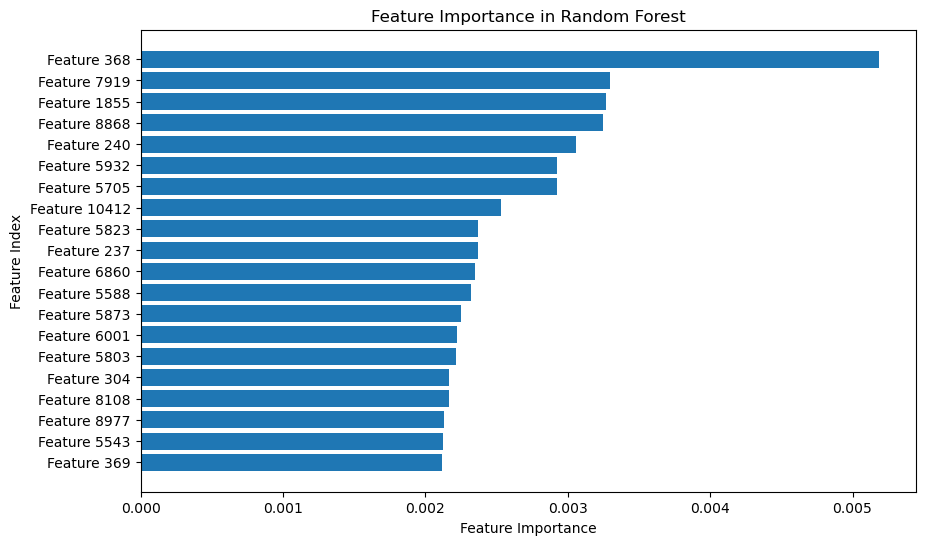

In [103]:
import matplotlib.pyplot as plt
import numpy as np
# I visualize the top features for random forest splitting
feature_importances = best_rf_model.feature_importances_

sorted_idx = np.argsort(feature_importances)[::-1]
top_n = 20  

plt.figure(figsize=(10,6))
plt.barh(range(top_n), feature_importances[sorted_idx[:top_n]], align='center')
plt.yticks(range(top_n), [f'Feature {i}' for i in sorted_idx[:top_n]])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Index")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()
plt.show()


Feature Importance Description:

While the graph is interesting, not much can be extracted from this visualization, as I am unsure which feature is "Feature 368". However, I believe that this trend is still interesting, and will keep it in the notebook.

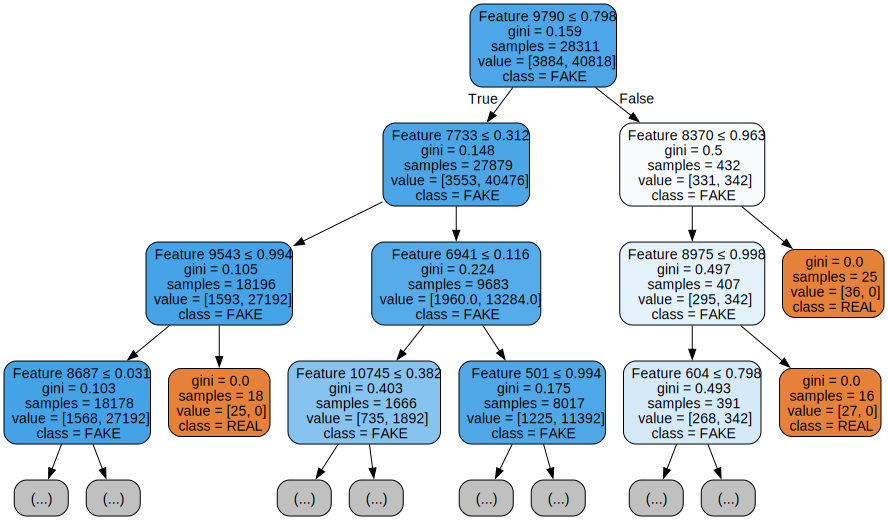

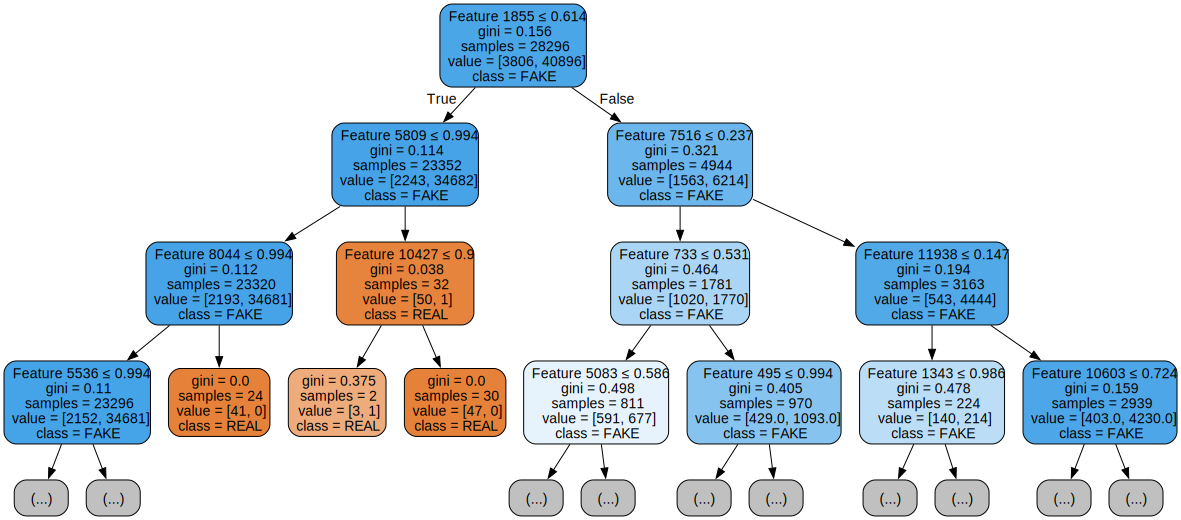

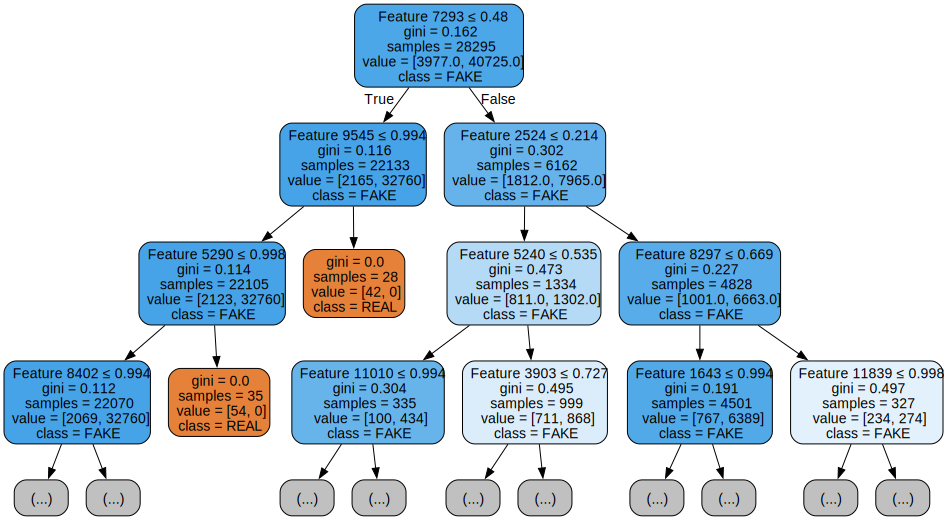

In [101]:
from sklearn.tree import export_graphviz
import graphviz
import random
# I visualize a few of the trees here, cut for eas
num_trees_to_visualize = 3
selected_trees = random.sample(best_rf_model.estimators_, num_trees_to_visualize)

for i, tree in enumerate(selected_trees):
    dot_data = export_graphviz(
        tree,  
        out_file=None,  
        feature_names=[f'Feature {i}' for i in range(X_train.shape[1])],  
        class_names=['REAL', 'FAKE'],  
        filled=True, 
        rounded=True, 
        special_characters=True, 
        max_depth=3 
    )
    
    graph = graphviz.Source(dot_data)
    graph.render(f"decision_tree_{i+1}", format="pdf")  
    display(graph) 



Randomly sampled trees from RF ML model description:

Each tree represents an independent set of decision rules learned from the dataset. These visualizations show how different features influence the classification between real and fake frames. The root node represents the feature with the highest information gain. As the tree moves downward, the splits become more granular—separating the dataset into progressively smaller subgroups. Each leaf node represents a classification outcome of real or fake. Some trees have deeper splits, suggesting that certain features require multiple conditions to distinguish real versus fake. Overly deep trees can consequently overfit the training data, but RF mitigates this by averaging multiple trees.

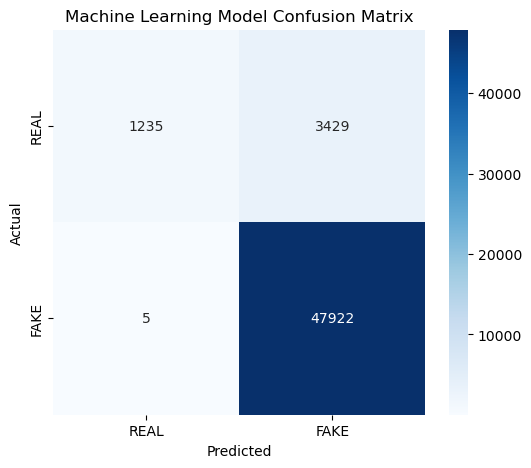

In [87]:
# I compute the confusion matrix for testing set here
cm_ml = confusion_matrix(y_test, y_pred_ml)
plt.figure(figsize=(6,5))
sns.heatmap(cm_ml, annot=True, fmt="d", cmap="Blues", xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Machine Learning Model Confusion Matrix')
plt.show()


ML Confusion Matrix Explanation:

The model correctly identifed 47,922 fake frames and 1,235 real frames. There is an imbalance in performance, as the model prioritizes deepfake detection at the cost of misclassifying real frames, leading to a high FP rate. 

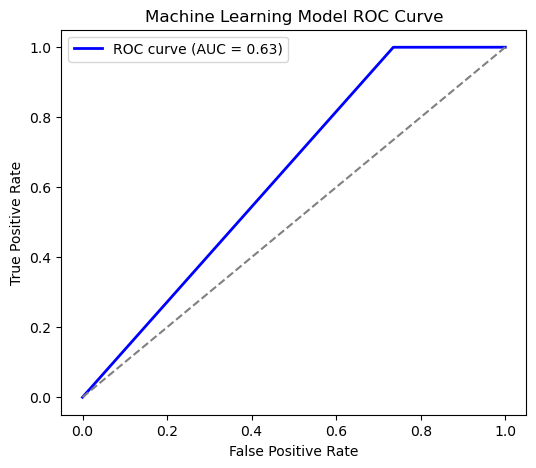

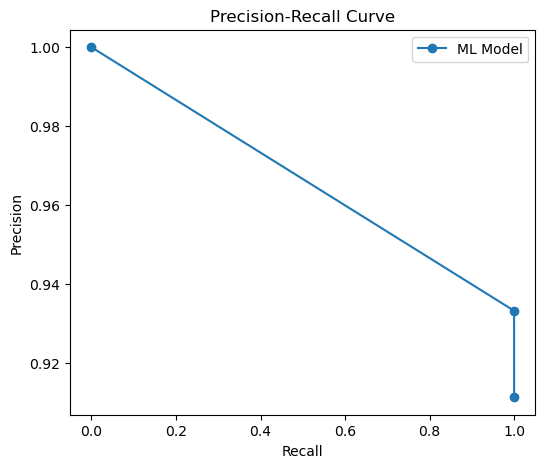

In [80]:
# I Compute ROC curve and precision-recall curve for testing set here 
fpr, tpr, _ = roc_curve(y_test, y_pred_ml)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Machine Learning Model ROC Curve")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_ml)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, marker='o', linestyle="-", label="ML Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


ROC Curve Explanation:

The ROC curve's shape suggests that the ML model is performing only slightly better than random guessing (AUC = 0.5). The curve's score (0.63) indicates that the model is struggling with distinguishing between real and fake, particularly due to the high FP rate, where real frames are classified as fake. The shape also suggests that the model can achieve a higher TP rate but at the cost of increasing FPs.

Precision-Recall Curve Explanation:

The model achieves high recall, capturing most fake frames. However, precision declines as recall increases, indicating that many real frames are being classified as fake. The model is more biased toward maximizing recall than balancing precision, which algins with the high FP rate.

### Error Analysis (Both Models)

The following illustrates example frames misclassified by the model.

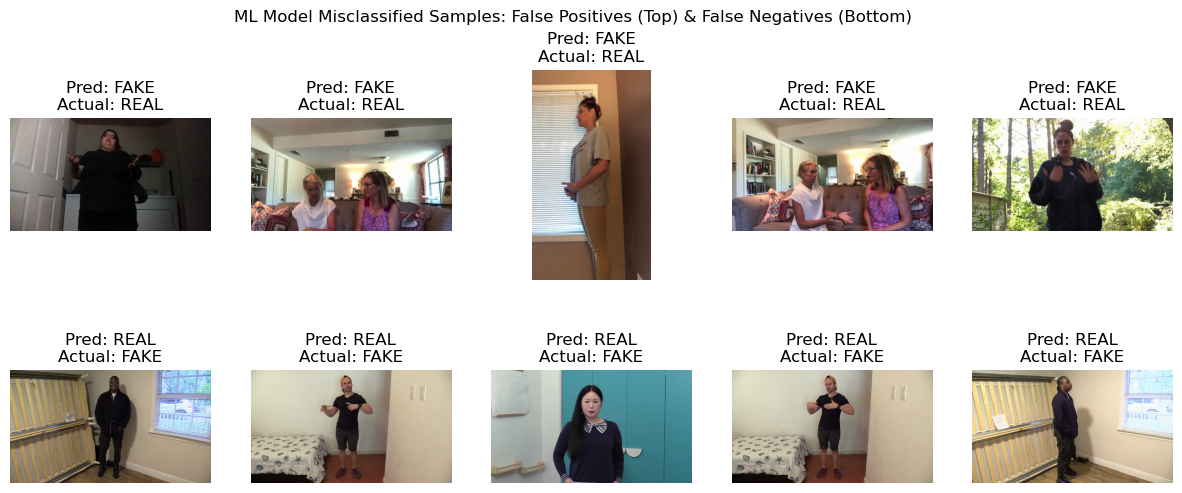

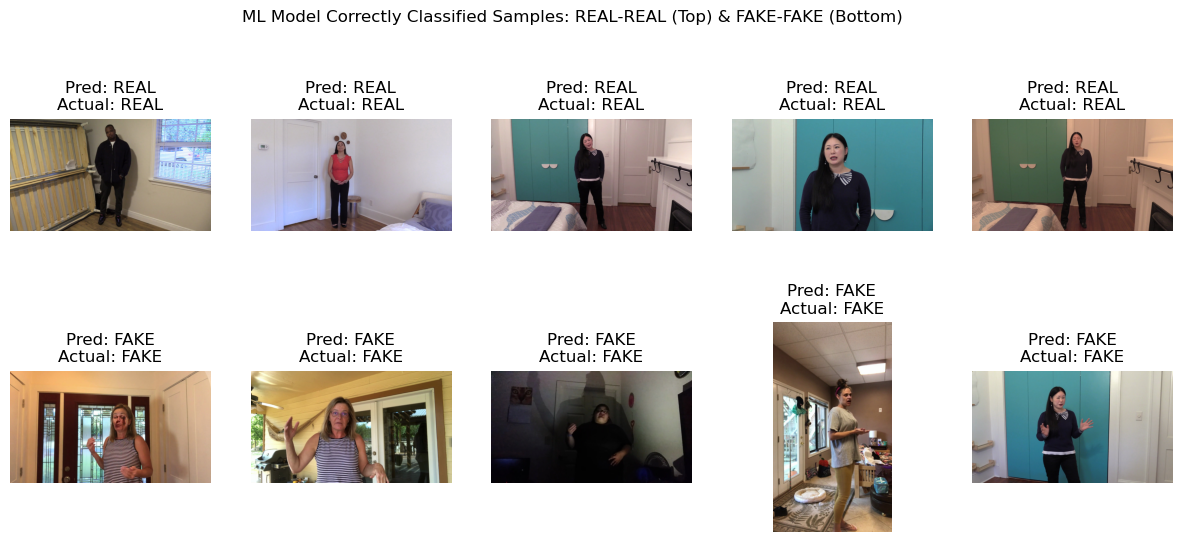

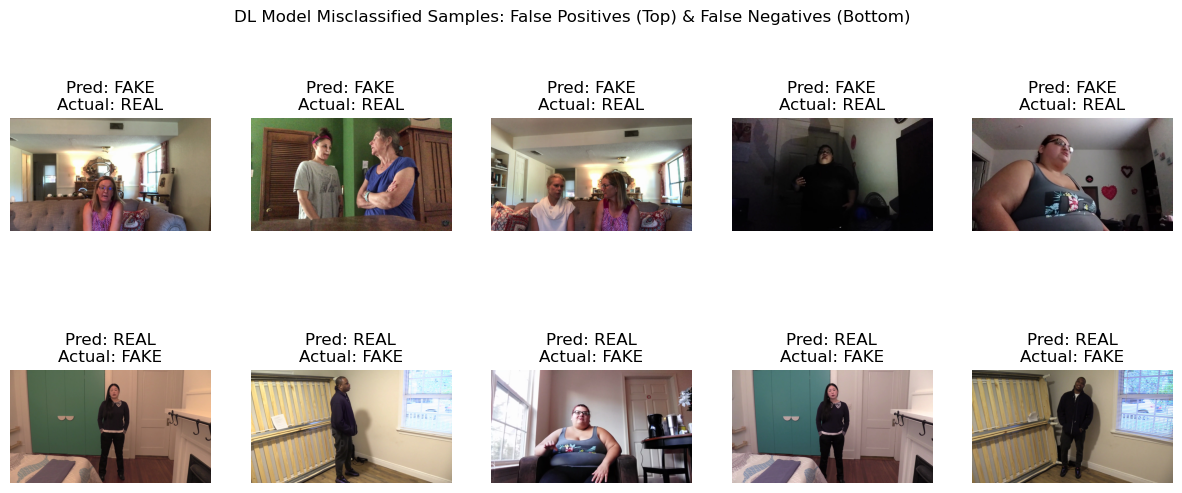

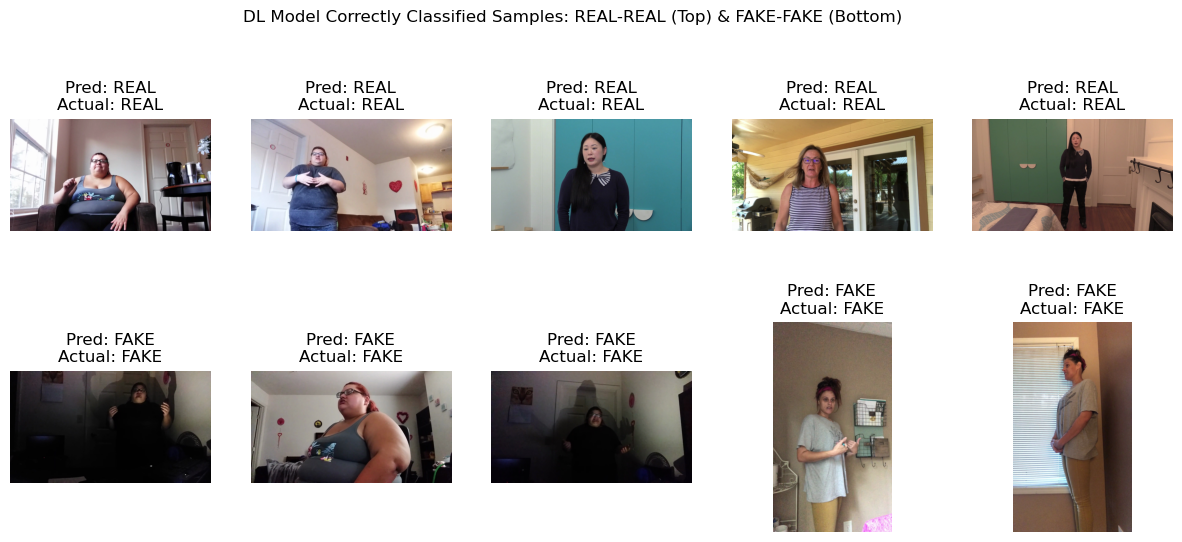

In [108]:
import matplotlib.pyplot as plt
import random
from PIL import Image

frame_paths = df_ml["frame_path"].values

# This identifies misclassified samples
false_positives_ml = [i for i in range(len(y_test)) if y_test[i] == 0 and y_pred_ml[i] == 1]
false_negatives_ml = [i for i in range(len(y_test)) if y_test[i] == 1 and y_pred_ml[i] == 0]
true_real_ml = [i for i in range(len(y_test)) if y_test[i] == 0 and y_pred_ml[i] == 0]  
true_fake_ml = [i for i in range(len(y_test)) if y_test[i] == 1 and y_pred_ml[i] == 1]
false_positives_dl = [i for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1]
false_negatives_dl = [i for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0]
true_real_dl = [i for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 0]
true_fake_dl = [i for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1]

fp_samples_ml = random.sample(false_positives_ml, min(5, len(false_positives_ml)))
fn_samples_ml = random.sample(false_negatives_ml, min(5, len(false_negatives_ml)))
true_real_samples_ml = random.sample(true_real_ml, min(5, len(true_real_ml)))
true_fake_samples_ml = random.sample(true_fake_ml, min(5, len(true_fake_ml)))

fp_samples_dl = random.sample(false_positives_dl, min(5, len(false_positives_dl)))
fn_samples_dl = random.sample(false_negatives_dl, min(5, len(false_negatives_dl)))
true_real_samples_dl = random.sample(true_real_dl, min(5, len(true_real_dl)))
true_fake_samples_dl = random.sample(true_fake_dl, min(5, len(true_fake_dl)))

# --- ML Model: Misclassified Samples ---
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("ML Model Misclassified Samples: False Positives (Top) & False Negatives (Bottom)")

for i, idx in enumerate(fp_samples_ml):
    img = Image.open(frame_paths[idx]).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].set_title("Pred: FAKE\nActual: REAL")
    axes[0, i].axis("off")

for i, idx in enumerate(fn_samples_ml):
    img = Image.open(frame_paths[idx]).convert("RGB")
    axes[1, i].imshow(img)
    axes[1, i].set_title("Pred: REAL\nActual: FAKE")
    axes[1, i].axis("off")

plt.show()

# --- ML Model: Correctly Classified Samples ---
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("ML Model Correctly Classified Samples: REAL-REAL (Top) & FAKE-FAKE (Bottom)")

for i, idx in enumerate(true_real_samples_ml):
    img = Image.open(frame_paths[idx]).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].set_title("Pred: REAL\nActual: REAL")
    axes[0, i].axis("off")

for i, idx in enumerate(true_fake_samples_ml):
    img = Image.open(frame_paths[idx]).convert("RGB")
    axes[1, i].imshow(img)
    axes[1, i].set_title("Pred: FAKE\nActual: FAKE")
    axes[1, i].axis("off")

plt.show()

# --- DL Model: Misclassified Samples ---
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("DL Model Misclassified Samples: False Positives (Top) & False Negatives (Bottom)")

for i, idx in enumerate(fp_samples_dl):
    img = Image.open(frame_paths[idx]).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].set_title("Pred: FAKE\nActual: REAL")
    axes[0, i].axis("off")

for i, idx in enumerate(fn_samples_dl):
    img = Image.open(frame_paths[idx]).convert("RGB")
    axes[1, i].imshow(img)
    axes[1, i].set_title("Pred: REAL\nActual: FAKE")
    axes[1, i].axis("off")

plt.show()

# --- DL Model: Correctly Classified Samples ---
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("DL Model Correctly Classified Samples: REAL-REAL (Top) & FAKE-FAKE (Bottom)")

for i, idx in enumerate(true_real_samples_dl):
    img = Image.open(frame_paths[idx]).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].set_title("Pred: REAL\nActual: REAL")
    axes[0, i].axis("off")

for i, idx in enumerate(true_fake_samples_dl):
    img = Image.open(frame_paths[idx]).convert("RGB")
    axes[1, i].imshow(img)
    axes[1, i].set_title("Pred: FAKE\nActual: FAKE")
    axes[1, i].axis("off")

plt.show()
